# Data Science Analyze and Present A/B Test Results

X company recently introduced a new bidding type, “average bidding”, as an alternative to its exisiting bidding
type, called “maximum bidding”. One of our clients, X.com, has decided to test this new feature
and wants to conduct an A/B test to understand if average bidding brings more conversions than maximum
bidding.

In this A/B test, X.com randomly splits its audience into two equally sized groups, e.g. the test
and the control group. A X company ad campaign with “maximum bidding” is served to “control group” and
another campaign with “average bidding” is served to the “test group”.

The A/B test has run for 1 month and X.com now expects you to analyze and present the results
of this A/B test.



##### You should answer the following questions in this notebook

1. How would you define the hypothesis of this A/B test?
2. Can we conclude statistically significant results?
3. Which statistical test did you use, and why?
4. Based on your answer to Question 2, what would be your recommendation to client?


##### Hints:

1. The customer journey for this campaign is:
    1. User sees an ad (Impression)
    2. User clicks on the website link on the ad (Website Click)
    3. User makes a search on the website (Search)
    4. User views details of a product (View Content)
    5. User adds the product to the cart (Add to Cart)
    6. User purchases the product (Purchase)
2. Use visualizations to compare test and control group metrics, such as Website Click Through Rate, Cost per Action, and Conversion Rates in addition to Purchase numbers.
3. If you see trends, anomalies or other patterns, discuss these in your notebool.
4. You can make assumptions if needed.


## 1. Import libraries

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skewtest
from scipy.stats import median_test
from scipy.stats import shapiro
import pylab
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import levene
from statsmodels.stats.proportion import proportions_ztest
from sklearn.impute import KNNImputer

pd.set_option("display.max_columns",None);
pd.set_option("display.max_rows",None);

## 2. Functions

In [45]:
def read_data() :
    """
      Reads and loads control and test group data from an Excel file.
    - **Control group** (Maximum Bidding): Existing campaign data.
    - **Test group** (Average Bidding): Data from the new bidding strategy.
    The function removes rows with NaN values that originated from notes in the Excel file for the control group.
    """
   # Load the control and test datasets
    control = pd.read_csv("/Users/margotiamanova/Desktop/DI-Bootcamp/Week7/Day5/ExerciseXP/control_group.csv", sep=';')
    test = pd.read_csv("/Users/margotiamanova/Desktop/DI-Bootcamp/Week7/Day5/ExerciseXP/test_group.csv", sep=';')

    # Check the size of the control dataframe before dropping rows
    print(f"Control dataframe size: {control.shape}")

    # Drop rows 30 and 31 only if they exist
    if len(control) > 30:
        control.drop(control.index[[30, 31]], inplace=True)
    else:
        print("Rows 30 and 31 do not exist in the control dataframe.")

    return control, test

def get_catvar(df) :
    """
    Identifies and extracts categorical variables from a DataFrame.
    - Returns the original DataFrame, a DataFrame of only categorical variables, and the names of the categorical columns.
    """
    cat_col = [col for col in df.columns if ( (df[col].dtype == 'object') | (df[col].dtype == 'bool'))]
    kat_df = pd.DataFrame(df[cat_col], index = df[cat_col].index)
    return df, kat_df, cat_col

def get_numvar(cat_col,df):
    """
    Identifies and extracts numerical variables from a DataFrame, excluding those specified as categorical.
    - Returns the original DataFrame, a DataFrame of only numerical variables, and the names of the numerical columns.
    """
    num_col = [c for c in df.columns if c not in cat_col]
    num_df = pd.DataFrame(df[num_col], index = df[num_col].index)
    return df, num_df, num_col

def fill_NaNValue(num_control) :
    """
    Implements K-Nearest Neighbors Imputation to fill in missing values in numerical columns of the control group.
    - Returns a DataFrame with missing values filled.
    """
    cols = num_control.columns
    imputer = KNNImputer(n_neighbors=8)
    num_control = imputer.fit_transform(num_control)
    num_control=pd.DataFrame(num_control,columns=cols)
    return num_control

def convert_datatype(control):
    """
      Converts specified columns in the control group DataFrame to integer data types.
    - This is important for ensuring data consistency and correctness in calculations.
    """
    control = control.astype({'# of Impressions' : 'int64',
                        'Reach': 'int64',
                        '# of Website Clicks' : 'int64',
                        '# of Searches': 'int64',
                        '# of View Content': 'int64',
                        '# of Add to Cart': 'int64',
                        '# of Purchase' : 'int64'})
    return control

def outliers(control, test):
    """
    Detects and handles outliers in the test group data using Local Outlier Factor (LOF).
    - Prints scores of the detected outliers and modifies extreme outlier values based on a specified threshold.
    """
    clf= LocalOutlierFactor(n_neighbors = 20, contamination = 0.1)
    clf.fit_predict(test.iloc[:,2:])[0:10]

    test_scores=clf.negative_outlier_factor_
    print("Test Score: " , np.sort(test_scores)[0:20])
    sns.boxplot(test_scores);

    threshold=np.sort(test_scores)[4]
    print("Threshold score: ", threshold)

    test.loc[test_scores < -1.50].index
    test.loc[test_scores == threshold]

    test.iloc[0,2:]=[2742.245945,79574,57168,3086,1263,1098,226,277]
    sns.boxplot(x="variable", y="value", data=pd.melt(test.iloc[:,3:5]));
    sns.boxplot(x="variable", y="value", data=pd.melt(test.iloc[:,5:6]));
    sns.boxplot(x="variable", y="value", data=pd.melt(test.iloc[:,6:]));


def feature_engineering(control, test):
    """
    Creates new features for both control and test groups to aid in analysis:
    - Website Click Through Rate: The percentage of clicks per number of impressions.
    - Number of Action: Sum of various engagement metrics like impressions, clicks, etc.
    - Cost per Action: The spend divided by the number of actions.
    - Conversion Rate: The number of actions divided by the number of clicks, expressed as a percentage.
    """
    control["Website Click Through Rate"] = control["# of Website Clicks"] / control["# of Impressions"] * 100
    test["Website Click Through Rate"] = test["# of Website Clicks"] / test["# of Impressions"] * 100

    control["Number of Action"] = control["# of Impressions"] + control["# of Website Clicks"] + control["# of Searches"] + control["# of View Content"] + control["# of Add to Cart"] + control["# of Purchase"]
    test["Number of Action"] = test["# of Impressions"] + test["# of Website Clicks"] + test["# of Searches"] + test["# of View Content"] + test["# of Add to Cart"] + test["# of Purchase"]

    control["Cost per Action"] = control["Spend [USD]"] / control["Number of Action"]
    test["Cost per Action"] = test["Spend [USD]"] / test["Number of Action"]

    control["Conversion Rate"] = control["Number of Action"] / control["# of Website Clicks"] * 100
    test["Conversion Rate"] = test["Number of Action"] / test["# of Website Clicks"] * 100

    return control, test

def data_prepare_for_visualization(control,test):
    """
    Prepares control and test group data for visualization by extracting specific metrics and labeling them for group comparison.
    - Returns a consolidated DataFrame of both groups for visualization purposes.
    """
    control_nop = pd.DataFrame(control["# of Purchase"])
    test_nop = pd.DataFrame(test["# of Purchase"])

    control_wctr= pd.DataFrame(control["Website Click Through Rate"])
    test_wctr= pd.DataFrame(test["Website Click Through Rate"])

    control_cpa= pd.DataFrame(control["Cost per Action"])
    test_cpa= pd.DataFrame(test["Cost per Action"])

    control_cr= pd.DataFrame(control["Conversion Rate"])
    test_cr= pd.DataFrame(test["Conversion Rate"])

    Group_A = pd.concat([control_nop, control_wctr, control_cpa, control_cr], axis = 1)
    Group_A["Group"] = "A (MaximumBidding)"

    Group_B = pd.concat([test_nop, test_wctr, test_cpa, test_cr], axis = 1)
    Group_B["Group"] = "B (AverageBidding)"

    #Tum veri
    AB = pd.concat([Group_A, Group_B])
    AB
    return AB, control_nop, test_nop

def data_prepare_for_hypothesis_testing(control_nop, test_nop):
    """
    Prepares control and test group data for hypothesis testing by combining "# of Purchase" data into a single DataFrame.
    - The resulting DataFrame is structured for direct comparison between groups.
    """
    controlB = pd.concat([control_nop, test_nop], axis = 1)
    controlB.columns = ["A","B"]
    return controlB

def num_boxplot(fig, axarr, dimension, cols, hue):
    """
    A helper function for plotting boxplots of numerical data, categorized by the experiment group.
    - It iterates over specified dimensions and columns to generate boxplots for visual analysis.
    """
    for i in dimension :
        for j in dimension :
            for c in cols :
                sns.boxplot(y=c, x = hue, hue = hue, data = AB, ax=axarr[i][j])
                cols.remove(c)
                break

def show_boxplot(nrows, ncols, boyut, cols, figsize):
    """
    Generates boxplots for the specified columns and groups, utilizing `num_boxplot`.
    - Allows specification of the number of rows and columns in the figure, and figure size.
    """
    fig, axarr = plt.subplots(nrows, ncols, figsize=figsize)
    num_boxplot(fig, axarr, boyut, cols, "Group")


def checkReject(p_value, alpha = 0.05):
    """
    Checks whether the p-value from hypothesis testing is significant enough to reject the null hypothesis, given an alpha level (default 0.05).
    - Prints the outcome of the hypothesis test in the context of rejecting or not rejecting the null hypothesis.
    """
    if p_value < alpha :
        print(f'{p_value} < alpha(0.05) so >>> H0 REJECTED')

    elif p_value > alpha :
        print(f'{p_value} > alpha(0.05) so >>> H0 CAN\'T BE REJECTED')

## 3. Data Preparation

In [46]:
# TODO : Import the dataset available here : https://www.kaggle.com/code/dillonmyrick/a-b-test-hypothesis-testing-for-e-commerce/input

In [47]:
control, test = read_data()

Control dataframe size: (30, 10)
Rows 30 and 31 do not exist in the control dataframe.


In [48]:
#TODO : print what is control
print(control)
control.shape

       Campaign Name        Date  Spend [USD]  # of Impressions     Reach  \
0   Control Campaign   1.08.2019         2280           82702.0   56930.0   
1   Control Campaign   2.08.2019         1757          121040.0  102513.0   
2   Control Campaign   3.08.2019         2343          131711.0  110862.0   
3   Control Campaign   4.08.2019         1940           72878.0   61235.0   
4   Control Campaign   5.08.2019         1835               NaN       NaN   
5   Control Campaign   6.08.2019         3083          109076.0   87998.0   
6   Control Campaign   7.08.2019         2544          142123.0  127852.0   
7   Control Campaign   8.08.2019         1900           90939.0   65217.0   
8   Control Campaign   9.08.2019         2813          121332.0   94896.0   
9   Control Campaign  10.08.2019         2149          117624.0   91257.0   
10  Control Campaign  11.08.2019         2490          115247.0   95843.0   
11  Control Campaign  12.08.2019         2319          116639.0  100189.0   

(30, 10)

In [49]:
#TODO : print what is test
print(test)
test.shape

    Campaign Name        Date  Spend [USD]  # of Impressions   Reach  \
0   Test Campaign   1.08.2019         3008             39550   35820   
1   Test Campaign   2.08.2019         2542            100719   91236   
2   Test Campaign   3.08.2019         2365             70263   45198   
3   Test Campaign   4.08.2019         2710             78451   25937   
4   Test Campaign   5.08.2019         2297            114295   95138   
5   Test Campaign   6.08.2019         2458             42684   31489   
6   Test Campaign   7.08.2019         2838             53986   42148   
7   Test Campaign   8.08.2019         2916             33669   20149   
8   Test Campaign   9.08.2019         2652             45511   31598   
9   Test Campaign  10.08.2019         2790             95054   79632   
10  Test Campaign  11.08.2019         2420             83633   71286   
11  Test Campaign  12.08.2019         2831            124591   10598   
12  Test Campaign  13.08.2019         1972             65827   4

(30, 10)

In [50]:
#TODO : check for null values in control
print(control.isnull().sum())

Campaign Name          0
Date                   0
Spend [USD]            0
# of Impressions       1
Reach                  1
# of Website Clicks    1
# of Searches          1
# of View Content      1
# of Add to Cart       1
# of Purchase          1
dtype: int64


In [51]:
# data types for control
print(control.dtypes)

Campaign Name           object
Date                    object
Spend [USD]              int64
# of Impressions       float64
Reach                  float64
# of Website Clicks    float64
# of Searches          float64
# of View Content      float64
# of Add to Cart       float64
# of Purchase          float64
dtype: object


In [52]:
#TODO : segment the control DataFrame into two separate DataFrames based on data type: one for categorical variables (kat_control) and one for numerical variables (num_control).
#TODO :produces lists of column names for both categories for further use or reference.

# Segment the control DataFrame into categorical and numerical DataFrames
kat_control = control.select_dtypes(include=['object', 'category'])  # Categorical variables
num_control = control.select_dtypes(include=['number'])  # Numerical variables

# Produce lists of column names for both categories
kat_columns = kat_control.columns.tolist()
num_columns = num_control.columns.tolist()

# Display the results
print("Categorical Columns:", kat_columns)
print("Numerical Columns:", num_columns)

# Optional: Display the first few rows of each segmented DataFrame
print("\nCategorical DataFrame (kat_control):")
print(kat_control.head())

print("\nNumerical DataFrame (num_control):")
print(num_control.head())

Categorical Columns: ['Campaign Name', 'Date']
Numerical Columns: ['Spend [USD]', '# of Impressions', 'Reach', '# of Website Clicks', '# of Searches', '# of View Content', '# of Add to Cart', '# of Purchase']

Categorical DataFrame (kat_control):
      Campaign Name       Date
0  Control Campaign  1.08.2019
1  Control Campaign  2.08.2019
2  Control Campaign  3.08.2019
3  Control Campaign  4.08.2019
4  Control Campaign  5.08.2019

Numerical DataFrame (num_control):
   Spend [USD]  # of Impressions     Reach  # of Website Clicks  \
0         2280           82702.0   56930.0               7016.0   
1         1757          121040.0  102513.0               8110.0   
2         2343          131711.0  110862.0               6508.0   
3         1940           72878.0   61235.0               3065.0   
4         1835               NaN       NaN                  NaN   

   # of Searches  # of View Content  # of Add to Cart  # of Purchase  
0         2290.0             2159.0            1819.0    

In [53]:
# TODO : Fill the control dataframe values NaN value with KNNImputer.

# Select only numerical columns for imputation
numerical_cols = control.select_dtypes(include=['number']).columns
# Apply KNN Imputer
imputer = KNNImputer(n_neighbors=8)  # You can adjust the number of neighbors
control[numerical_cols] = imputer.fit_transform(control[numerical_cols])

# Check if NaN values are filled
print(control.isnull().sum())  # Should print 0 for all numerical columns

Campaign Name          0
Date                   0
Spend [USD]            0
# of Impressions       0
Reach                  0
# of Website Clicks    0
# of Searches          0
# of View Content      0
# of Add to Cart       0
# of Purchase          0
dtype: int64


In [54]:
# TODO : Combine categorical and numerical variables with the concept.

# Apply KNNImputer on numeric variables
imputer = KNNImputer(n_neighbors=8)
num_control_imputed = pd.DataFrame(imputer.fit_transform(num_control), columns=num_control.columns)
#  Recombine DataFrames
control_imputed = pd.concat([num_control_imputed, kat_control], axis=1)

# NaN Verification
print(control_imputed.isnull().sum())

Spend [USD]            0
# of Impressions       0
Reach                  0
# of Website Clicks    0
# of Searches          0
# of View Content      0
# of Add to Cart       0
# of Purchase          0
Campaign Name          0
Date                   0
dtype: int64


In [55]:
# Let's do a data type conversion.

control = convert_datatype(control)

print(control.shape)
print(test.shape)

(30, 10)
(30, 10)


In [56]:
# Check your dataframes

print(control.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Campaign Name        30 non-null     object 
 1   Date                 30 non-null     object 
 2   Spend [USD]          30 non-null     float64
 3   # of Impressions     30 non-null     int64  
 4   Reach                30 non-null     int64  
 5   # of Website Clicks  30 non-null     int64  
 6   # of Searches        30 non-null     int64  
 7   # of View Content    30 non-null     int64  
 8   # of Add to Cart     30 non-null     int64  
 9   # of Purchase        30 non-null     int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 2.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Campaign Name        30 

## 4. Preparing Data for Hypothesis Testing (A/B Test)



In [57]:
#TODO : Apply the feature engineering on control and test, what does the function do exactly ?

#TODO : Prepare and generate features for visualization with the help of a function

print(feature_engineering(control, test))


print(data_prepare_for_visualization(control,test))

AB, control_nop, test_nop = data_prepare_for_visualization(control,test)

(       Campaign Name        Date  Spend [USD]  # of Impressions   Reach  \
0   Control Campaign   1.08.2019       2280.0             82702   56930   
1   Control Campaign   2.08.2019       1757.0            121040  102513   
2   Control Campaign   3.08.2019       2343.0            131711  110862   
3   Control Campaign   4.08.2019       1940.0             72878   61235   
4   Control Campaign   5.08.2019       1835.0            100341   82046   
5   Control Campaign   6.08.2019       3083.0            109076   87998   
6   Control Campaign   7.08.2019       2544.0            142123  127852   
7   Control Campaign   8.08.2019       1900.0             90939   65217   
8   Control Campaign   9.08.2019       2813.0            121332   94896   
9   Control Campaign  10.08.2019       2149.0            117624   91257   
10  Control Campaign  11.08.2019       2490.0            115247   95843   
11  Control Campaign  12.08.2019       2319.0            116639  100189   
12  Control Campaign  13

Let's look at the numbers A and B.

In [58]:
AB["Group"].value_counts()

Group
A (MaximumBidding)    30
B (AverageBidding)    30
Name: count, dtype: int64

### 4.1. Website Click Through Rate (CTR)
Review :
- It is a rate that shows how often the users who saw the ad CLICK the ad.
- Number of Ad Clicks / Number of Ad Displays
- Example: 5 clicks, CTR at 100 impressions = 5%

- ##### Use visualizations to compare test and control group metrics, such as Website Click Through Rate, Cost per Action, and Conversion Rates in addition to Purchase numbers.

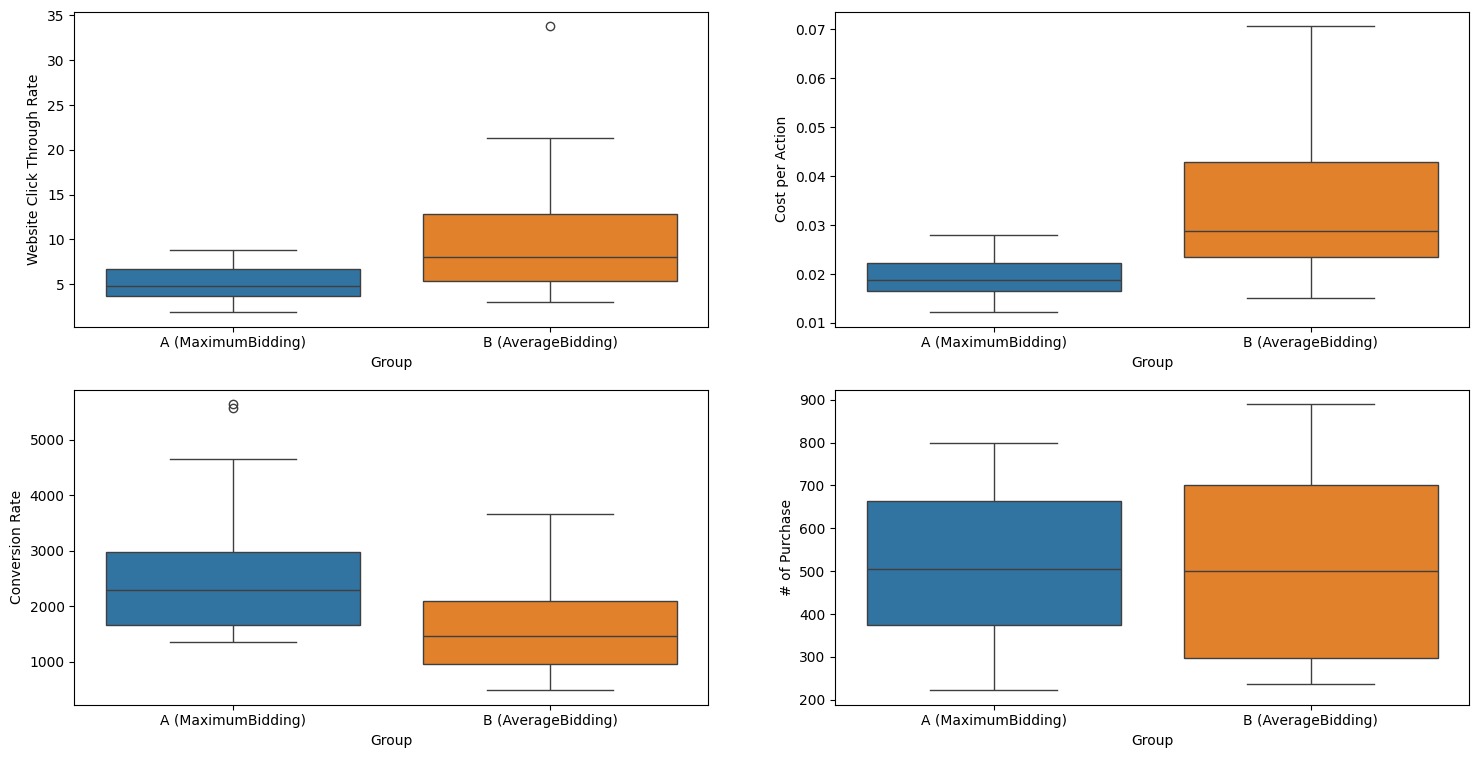

In [59]:
cols = ["Website Click Through Rate","Cost per Action","Conversion Rate","# of Purchase"]
show_boxplot(2,2,[0,1],cols,(18,9))

In [60]:
#TODO : create your dataframe for AB test and print the first 3 rows of it.


AB.head(3)



,# of Purchase,Website Click Through Rate,Cost per Action,Conversion Rate,Group
0,618,8.483471,0.023602,1376.909920,A (MaximumBidding)
1,511,6.700264,0.013039,1661.578298,A (MaximumBidding)
2,372,4.941121,0.016383,2197.464659,A (MaximumBidding)


## 5. Two Independent Sample T-Test
### 5.1. Assumption Check
#### 5.1.1. Normality Assumption (shapiro test)

 * **H0**: Normal distribution assumption is provided.
 * **H1**: ... not provided.

In [61]:
#TODO : Aply the normality assumption of the dataframe for A


# Filter data for group "A" (MaximumBidding)
group_A = AB[AB["Group"] == "A (MaximumBidding)"]

# List of numeric columns to test for normality
numeric_columns = ["# of Purchase", "Website Click Through Rate", "Cost per Action", "Conversion Rate"]

# Dictionary for storing normality test results

normality_results = {}

# Apply the Shapiro-Wilk normality test to each numeric column
for col in numeric_columns:
    stat, p_value = shapiro(group_A[col])
    normality_results[col] = {"Shapiro-Wilk Statistic": stat, "p-value":round(p_value,3)}
    checkReject(p_value)
# Displaying results
print(normality_results)



0.10821626663232112 > alpha(0.05) so >>> H0 CAN'T BE REJECTED
0.32907455487330894 > alpha(0.05) so >>> H0 CAN'T BE REJECTED
0.5539041432256376 > alpha(0.05) so >>> H0 CAN'T BE REJECTED
0.0006150598807929507 < alpha(0.05) so >>> H0 REJECTED
{'# of Purchase': {'Shapiro-Wilk Statistic': np.float64(0.9427996417799834), 'p-value': np.float64(0.108)}, 'Website Click Through Rate': {'Shapiro-Wilk Statistic': np.float64(0.9610314602178175), 'p-value': np.float64(0.329)}, 'Cost per Action': {'Shapiro-Wilk Statistic': np.float64(0.9705345565353987), 'p-value': np.float64(0.554)}, 'Conversion Rate': {'Shapiro-Wilk Statistic': np.float64(0.8498329788497665), 'p-value': np.float64(0.001)}}


In [62]:
#TODO : compute p_value for normality on group A from the df_AB dataframe and round it to three decimal places.
#TODO : pass it to a function checkReject to determine if the null hypothesis of normality should be rejected.
# Filter data for group "A" (MaximumBidding)
group_A = AB[AB["Group"] == "A (MaximumBidding)"]

# List of numeric columns to test for normality
numeric_columns = ["# of Purchase", "Website Click Through Rate", "Cost per Action", "Conversion Rate"]

# Dictionary for storing normality test results

normality_results = {}

# Apply the Shapiro-Wilk normality test to each numeric column
for col in numeric_columns:
    stat, p_value = shapiro(group_A[col])
    normality_results[col] = {"Shapiro-Wilk Statistic": stat, "p-value":round(p_value,3)}
    checkReject(p_value)
# Displaying results
print(normality_results)



0.10821626663232112 > alpha(0.05) so >>> H0 CAN'T BE REJECTED
0.32907455487330894 > alpha(0.05) so >>> H0 CAN'T BE REJECTED
0.5539041432256376 > alpha(0.05) so >>> H0 CAN'T BE REJECTED
0.0006150598807929507 < alpha(0.05) so >>> H0 REJECTED
{'# of Purchase': {'Shapiro-Wilk Statistic': np.float64(0.9427996417799834), 'p-value': np.float64(0.108)}, 'Website Click Through Rate': {'Shapiro-Wilk Statistic': np.float64(0.9610314602178175), 'p-value': np.float64(0.329)}, 'Cost per Action': {'Shapiro-Wilk Statistic': np.float64(0.9705345565353987), 'p-value': np.float64(0.554)}, 'Conversion Rate': {'Shapiro-Wilk Statistic': np.float64(0.8498329788497665), 'p-value': np.float64(0.001)}}


For most of the numerical variables in Group B, the null hypothesis of normality is rejected because the p-value is less than 0.05. However, the last variable, 'Conversion Rate,' does not lead to the rejection of the null hypothesis. As a result, the majority of numerical variables in Group B are not normally distributed

Does the HO hypothesis get rejected ? why ?

In [63]:
#TODO : Aply the normality assumption of the dataframe for B
# Filter data for group "B" (AverageBidding)
group_B = AB[AB["Group"] == "B (AverageBidding)"]

# List of numeric columns to test for normality
numeric_columns = ["# of Purchase", "Website Click Through Rate", "Cost per Action", "Conversion Rate"]

# Dictionary for storing normality test results
normality_results = {}

# Apply the Shapiro-Wilk normality test to each numeric column
for col in numeric_columns:
    stat, p_value = shapiro(group_B[col])
    normality_results[col] = {"Shapiro-Wilk Statistic": stat, "p-value":round(p_value,3)}
    checkReject(p_value)
# Displaying results
print(normality_results)

0.024077671296647205 < alpha(0.05) so >>> H0 REJECTED
0.00040253128934615795 < alpha(0.05) so >>> H0 REJECTED
0.0021231323087315015 < alpha(0.05) so >>> H0 REJECTED
0.10114981949466778 > alpha(0.05) so >>> H0 CAN'T BE REJECTED
{'# of Purchase': {'Shapiro-Wilk Statistic': np.float64(0.9181893816994648), 'p-value': np.float64(0.024)}, 'Website Click Through Rate': {'Shapiro-Wilk Statistic': np.float64(0.8409182166025057), 'p-value': np.float64(0.0)}, 'Cost per Action': {'Shapiro-Wilk Statistic': np.float64(0.8745912549918493), 'p-value': np.float64(0.002)}, 'Conversion Rate': {'Shapiro-Wilk Statistic': np.float64(0.9417117328567002), 'p-value': np.float64(0.101)}}


In [64]:
#TODO : compute p_value for normality on group B from the df_AB dataframe and round it to three decimal places.
#TODO : pass it to a function checkReject to determine if the null hypothesis of normality should be rejected.


from scipy.stats import shapiro

# Function to check if the null hypothesis should be rejected
def checkReject(p_value, alpha=0.05):
    """
    Determines if the null hypothesis of normality should be rejected.
    
    Parameters:
    - p_value: The p-value from the normality test.
    - alpha: The significance level (default is 0.05).
    
    Returns:
    - str: "Reject Null Hypothesis" or "Fail to Reject Null Hypothesis".
    """
    if p_value < alpha:
        return "Reject Null Hypothesis"
    else:
        return "Fail to Reject Null Hypothesis"

# Debugging: Print column names to verify structure
print("Columns in AB dataframe:", AB.columns)

# TODO: Compute p-value for normality on group B
try:
    group_B = AB[AB['Group'] == 'B']['Value']  # Replace 'Value' with the correct column name if needed
    stat, p_value = shapiro(group_B)  # Perform Shapiro-Wilk test for normality
    p_value_rounded = round(p_value, 3)  # Round p-value to three decimal places

    # Pass the p-value to the checkReject function
    result = checkReject(p_value_rounded)

    # Display the results
    print(f"Shapiro-Wilk Test Statistic: {stat}")
    print(f"P-Value (rounded): {p_value_rounded}")
    print(f"Result: {result}")
except KeyError as e:
    print(f"KeyError: {e}. Please check the column names in the AB dataframe.")

Columns in AB dataframe: Index(['# of Purchase', 'Website Click Through Rate', 'Cost per Action',
       'Conversion Rate', 'Group'],
      dtype='object')
KeyError: 'Value'. Please check the column names in the AB dataframe.


Does the HO hypothesis get rejected ? why ?

### 5.1.2. Variance Homogeneity Assumption
 * **H0** : Variances are homogeneous.
 * **H1** : Variances are not homogeneous.

We want to assess if A and B have equal variances, which is a common assumption for various statistical tests :

In [65]:
#TODO : Performs the Levene test for equality of variances on two groups, A and B, from the df_AB dataframe
levene_results = {}
# Retrieve groups A and B
group_A = AB[AB["Group"] == "A (MaximumBidding)"]
group_B = AB[AB["Group"] == "B (AverageBidding)"]


for col in AB.columns:
    if col == "Group":  # Ignore the 'Group' column
        continue

# Levene's test for equality of variances
    stat_levene, p_value_levene = stats.levene(group_A[col], group_B[col])
    levene_results[col] = {
        "Levene Statistic": stat_levene,
        "p-value": round(p_value_levene, 3),
        "H0 Rejected (Variances Différentes)": p_value_levene < 0.05
    }
    checkReject(p_value_levene)
df_levene = pd.DataFrame(levene_results).T

# Displaying results

print("\nResults of Levene's test (equality of variances) :\n", df_levene)


Results of Levene's test (equality of variances) :
                            Levene Statistic p-value  \
# of Purchase                      1.689928   0.199   
Website Click Through Rate        10.267404   0.002   
Cost per Action                   15.628275     0.0   
Conversion Rate                    1.655583   0.203   

                           H0 Rejected (Variances Différentes)  
# of Purchase                                            False  
Website Click Through Rate                                True  
Cost per Action                                           True  
Conversion Rate                                          False  


In [66]:
#TODO : compute the p_value of the df_AB dataframe and round it to three decimal places.
#TODO : pass it to a function checkReject to determine if the null hypothesis of normality should be rejected.

The variances of the two groups are homogeneous for two variables: 'Cost per Action' and 'Website Click Through Rate.' However, for the other numerical variables, the variances between the two groups are not homogeneous.




Conclude about the variances, are they homogeneous ?

### 5.1.3. Nonparametric Independent Two-Sample T-Test

- Since the normality of the distribution of the data set in which Average Bidding (Test Group) was measured was rejected, the NonParametric Independent Two-Sample T Test was applied for the Hypothesis Test.

**Hypothesis:**

 * **H0** : When it comes to Maximum Bidding and Average Bidding, there is no statistically significant difference between the purchasing amounts of the two groups. ($\mu_1 = \mu_2$)

 * **H1** : ... there is a difference ($\mu_1 \neq \mu_2$)

In [ ]:
# Average Biddingin (Test Group)
stats.mannwhitneyu(df_AB["A"], df_AB["B"])

In [ ]:
#TODO : compute the p_value of the df_AB dataframe and round it to three decimal places.
#TODO : pass it to a function checkReject to determine if the null hypothesis of normality should be rejected.
# Filter groups A and B for the variable "# of Purchase"
group_A = AB[AB["Group"] == "A (MaximumBidding)"]["# of Purchase"]
group_B = AB[AB["Group"] == "B (AverageBidding)"]["# of Purchase"]

# Perform the Mann-Whitney U test on the "# of Purchase" variable
stat, p_value = stats.mannwhitneyu(group_A, group_B, alternative='two-sided')

# Round the p-value to three decimal places
rounded_p_value = round(p_value, 3)

# Displaying results
print(f"Mann-Whitney U test on 'Purchasing' p-value: {rounded_p_value}")

# Check if H0 should be rejected
checkReject(rounded_p_value)

Mann-Whitney U test on 'Purchasing' p-value: 0.947


'Fail to Reject Null Hypothesis'

Should the H0 hypothesis be rejected ? Why ? What can you conclude ?

the p-value is greater than or equal to 0.05:

The null hypothesis (H₀) cannot be rejected.
This means there is no statistically significant difference between the two groups.

## 6. Conclusion and Evaluation


##### You should answer the following questions :


**1. How would you define the hypothesis of this A/B test ?**
H₀ (Null Hypothesis): There is no statistically significant difference in performance between the control group and the test group.
H₁ (Alternative Hypothesis): There is a statistically significant difference in performance between the control group and the test group.

   
**2. Can we conclude statistically significant results?**
If the p-value is less than 0.05, the null hypothesis (H₀) is rejected, indicating that the difference is statistically significant.
If the p-value is greater than 0.05, the null hypothesis (H₀) cannot be rejected, meaning there is insufficient evidence to conclude a significant difference.
  


**3. Which statistical test did you use, and why?**
   If the data follow a normal distribution, the Student's t-test (a parametric test) should be used.
If the data do not follow a normal distribution, the Mann-Whitney U test (a non-parametric test) is more appropriate.

The Shapiro-Wilk test can be applied to assess the normality of the data before selecting the appropriate statistical test.

Generate
    
**4. Based on your answer to Question 2, what would be your recommendation to client?**
Since there is no evidence of a significant difference in purchasing behavior between the two groups, it is recommended to maintain the current strategy (control group) rather than implementing the changes tested in the experiment. The new strategy does not appear to provide any measurable improvement in purchasing behavior.
   